## Import Libs

In [1]:
import os,sys
# install deepspeech - https://github.com/SeanNaren/deepspeech.pytorch
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import torch
import torch.nn as nn
import hydra


from hydra.core.config_store import ConfigStore
from deepspeech_pytorch.configs.inference_config import EvalConfig
from deepspeech_pytorch.loader.data_loader import SpectrogramDataset, AudioDataLoader
from deepspeech_pytorch.utils import load_model, load_decoder
from deepspeech_pytorch.validation import run_evaluation
from deepspeech_pytorch.model import DeepSpeech, SequenceWise

from utils import *

from ctc_loss_imp import ctc_loss_imp
import matplotlib
%matplotlib inline



In [2]:
# ------------------------------------------------------------------------------
# Config 
# ------------------------------------------------------------------------------
cs = ConfigStore.instance()
cs.store(name="config", node=EvalConfig)

cfg = EvalConfig()

# set bs = 1, device
cfg.batch_size=1
device = torch.device("cuda" if cfg.model.cuda else "cpu")


# ------------------------------------------------------------------------------
# Model
# ------------------------------------------------------------------------------
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/librispeech_pretrained_v3.ckpt'
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/outputs/2023-11-01/23-31-50/lightning_logs/version_0/checkpoints/epoch=5-step=19295.ckpt'
model_ds = DeepSpeech.load_from_checkpoint(model_path)
model_ds.train()
model_ds = model_ds.to(device)

# ------------------------------------------------------------------------------
# Data
# ------------------------------------------------------------------------------

test_dir = '/scratch/f006pq6/datasets/librispeech/test_clean'
test_dataset = SpectrogramDataset(
    audio_conf=model_ds.spect_cfg,
    input_path=hydra.utils.to_absolute_path(test_dir),
    labels=model_ds.labels,
    normalize=True
)
test_loader = AudioDataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers
)
# ------------------------------------------------------------------------------
# Get an Input
# ------------------------------------------------------------------------------


inputs, targets, input_percentages, target_sizes = next(iter(test_loader)) 
inputs = inputs.to(device)
targets = targets.to(device)


# # ==============================================================================
# # Make the input a bit smaller

inputs = inputs[:,:,:,-65:-40] # do 100 frames only
input_percentages[0] = 1.0
input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
input_percentages = input_percentages.to(device)

print('input shape:',inputs.shape)


input shape: torch.Size([1, 1, 161, 25])


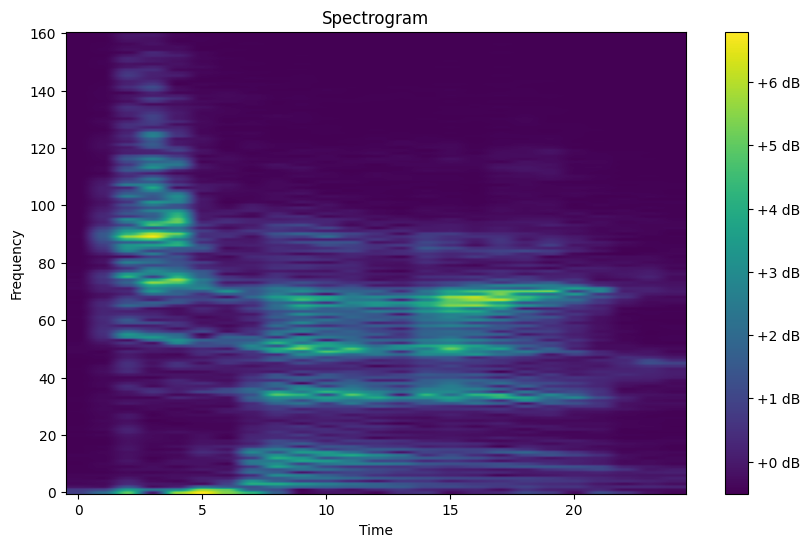

In [3]:
plot_spectrogram(inputs.detach())

In [4]:
# ------------------------------------------------------------------------------
#  Loss function, get target dL/dW
# ------------------------------------------------------------------------------
##get the param to match gradient
weight_param = model_ds.fc[0].module[1].weight
# weight_param = model_simple.fc2.weight
print('weight shape:', weight_param.shape)

out, output_sizes, hs = model_ds(inputs, input_sizes) # 1 176 29

# make target same size of output size
targets = targets[-out.shape[1]:]
target_sizes[0]= len(targets)


print('model input shape, input_sizes:', inputs.shape, input_sizes)
print('model output shape, output_sizes, hidden sizes:', out.shape, output_sizes, len(hs))
print('target sizes, targets: ', target_sizes, targets)

out = out.transpose(0, 1)  # TxNxH
out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log
# from torch.nn import CTCLoss
# loss_ = CTCLoss(blank=model_ds.labels.index('_'), reduction='sum', zero_infinity=True)(out, targets, output_sizes, target_sizes)
loss_func = lambda x,y :ctc_loss_imp(x, y, output_sizes, target_sizes,reduction='mean')


loss_func_lib   = torch.nn.CTCLoss()
loss = loss_func(out, targets)
loss_lib = loss_func_lib(out, targets, output_sizes, target_sizes)
print('loss:', loss.item())
print('loss by pt lib:', loss_lib.item())
# grab gradient to match
dldw_target= torch.autograd.grad(loss, weight_param)[0]

print('grad shape:',dldw_target.shape, 'grad_norm', dldw_target.norm())


weight shape: torch.Size([29, 1024])


model input shape, input_sizes: torch.Size([1, 1, 161, 25]) tensor([25], dtype=torch.int32)
model output shape, output_sizes, hidden sizes: torch.Size([1, 13, 29]) tensor([13], dtype=torch.int32) 5
target sizes, targets:  tensor([13], dtype=torch.int32) tensor([ 5, 20, 21, 28, 21,  9,  6, 28, 21,  6, 15, 21, 20], device='cuda:0')
loss: 6.230847037755526
loss by pt lib: 6.230847358703613
grad shape: torch.Size([29, 1024]) grad_norm tensor(10.7748, device='cuda:0')


In [31]:
# ------------------------------------------------------------------------------
# Meta loss
# ------------------------------------------------------------------------------
def meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param):
    loss = loss_func(output, targets)
    dldw = torch.autograd.grad(loss, weight_param, create_graph=True)[0]
    loss = ((dldw-dldw_target)**2).sum() #MSE
    #loss = 1 - torch.nn.functional.cosine_similarity(dldw.reshape(1,-1), dldw_target.reshape(1,-1))

    return loss,dldw

# ------------------------------------------------------------------------------
# Init random input
# ------------------------------------------------------------------------------

x_hat = torch.nn.Parameter(torch.rand_like(inputs).to(device),requires_grad=True)

out, output_sizes, hs = model_ds(x_hat, input_sizes) # 1 176 29
#out = model_ds(x_hat,input_sizes)
out = out.transpose(0, 1)  # TxNxH
out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

loss,dldw = meta_loss(out, targets, None, None, dldw_target,  weight_param)
print('loss, dldw norm:', loss.item(), torch.norm(dldw))

loss, dldw norm: 240.95913696289062 tensor(10.8617, device='cuda:0', grad_fn=<NormBackward1>)


In [32]:
x_hat.shape

torch.Size([1, 1, 161, 25])

In [119]:

# ------------------------------------------------------------------------------
# Train,  gradient 
# ------------------------------------------------------------------------------
#import torch.optim as optim
import math

import torch.optim as optim

if x_hat is not None and isinstance(x_hat, torch.Tensor):
    x_hat =  torch.nn.Parameter(x_hat,requires_grad=True)


optimizer = optim.Adam([x_hat], lr=1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=.5,patience=100)




i=0
loss_history = []
lr = 0.01
iter_per_block = 100
block_size = 5
while True:
    out, output_sizes, hs = model_ds(x_hat, input_sizes) # 1 176 29
    out = out.transpose(0, 1)  # TxNxH
    out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)

    optimizer.zero_grad()
    mloss.backward()
    grad = x_hat.grad.data

    optimizer.step()


    loss_history.append(mloss.item())
    if i % 10 == 0:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), optimizer.param_groups[0]["lr"]))


    if (i+ 1) % 10000 == 0:
        torch.save({
            'x_hat':x_hat.data,
            'loss_history': loss_history,
            #'optimizer': optimizer.state_dict(),
            #ĸ'scheduler': scheduler.state_dict(),
                }, f'input_checkpoint_{i+ 1}.pt')
        print(f'x_hat saved at iteration {i+ 1}')


    scheduler.step(mloss.item())
    i+=1

Iteration, Loss, Gradient Norm, Learning Rate:    0, 104.8912, 0.0741, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   10, 109.1180, 0.9695, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   20, 102.6516, 0.3101, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   30, 99.8711, 0.1615, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   40, 97.9790, 0.1149, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   50, 96.4611, 0.0759, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   60, 95.1121, 0.0548, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   70, 93.8017, 0.0506, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   80, 92.3512, 0.0972, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   90, 93.1846, 0.8468, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:  100, 91.3296, 0.3965, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:  110, 90.1049, 0.5334, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:  120, 89.3487, 0.9326, 1.0

KeyboardInterrupt: 

In [106]:
x_hat

Parameter containing:
tensor([[[[ 0.9486,  0.5968,  0.3205,  ...,  0.8297,  0.8651,  0.1444],
          [ 0.3844,  0.0965,  1.0782,  ...,  0.8609,  0.7163,  0.6809],
          [ 0.6841,  0.4299,  0.4075,  ...,  0.5684,  0.0968, -0.1823],
          ...,
          [ 1.0277,  0.0950,  0.9750,  ..., -0.0524,  0.4551,  0.3800],
          [-0.1382,  0.3139,  0.6148,  ...,  0.0630,  0.6594,  0.6295],
          [ 0.5355,  0.7636,  0.6157,  ...,  0.4981,  0.5748,  0.3978]]]],
       device='cuda:0')

In [45]:

# ------------------------------------------------------------------------------
# Train, altenating direction
# ------------------------------------------------------------------------------
#import torch.optim as optim
import math
i=0
loss_history = []
lr = 0.1
iter_per_block = 100
block_size = 5
while True:
    for idx_block in reversed(range(math.ceil(x_hat.shape[-1]//block_size))):
        for iter_per_block in range(iter_per_block):
            out, output_sizes, hs = model_ds(x_hat, input_sizes) # 1 176 29
            out = out.transpose(0, 1)  # TxNxH
            out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

            # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
            mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)


            #optimizer.zero_grad()
            # mloss.backward()


            #grad = x_hat.grad.data
            grad = torch.autograd.grad(mloss, x_hat)[0]

            #optimizer.step()
            start_block_idx = idx_block * block_size
            end_block_idx   = min((idx_block+1)*block_size, x_hat.shape[-1])
            x_new = x_hat.detach().clone()
            x_new[:,:,:,start_block_idx:end_block_idx] = x_new[:,:,:,start_block_idx:end_block_idx] \
                - lr * grad[:,:,:,start_block_idx:end_block_idx] 
            x_hat.data = x_new.data

            loss_history.append(mloss.item())

            if i % 10 == 0:
                print('Iteration, Loss, Gradient Norm, Learning Rate, start_block, end_block: {:4d}, {:.4f}, {:.4f}, {:.4f}, {:2d}, {:2d}'.format(i, mloss.item(), grad.norm().item(), 
                     lr, start_block_idx, end_block_idx))
                #scheduler.step(mloss.item())

            if (i+ 1) % 10000 == 0:
                torch.save({
                    'x_hat':x_hat.data,
                    'loss_history': loss_history,
                    #'optimizer': optimizer.state_dict(),
                    #ĸ'scheduler': scheduler.state_dict(),
                     }, f'input_checkpoint_{i+ 1}.pt')
                print(f'x_hat saved at iteration {i+ 1}')


            i+=1

Iteration, Loss, Gradient Norm, Learning Rate, start_block, end_block:    0, 122.8666, 8.2261, 0.1000, 20, 25
Iteration, Loss, Gradient Norm, Learning Rate, start_block, end_block:   10, 122.9518, 6.6088, 0.1000, 20, 25
Iteration, Loss, Gradient Norm, Learning Rate, start_block, end_block:   20, 122.7802, 5.6753, 0.1000, 20, 25
Iteration, Loss, Gradient Norm, Learning Rate, start_block, end_block:   30, 122.7292, 5.0489, 0.1000, 20, 25
Iteration, Loss, Gradient Norm, Learning Rate, start_block, end_block:   40, 122.6865, 4.6613, 0.1000, 20, 25
Iteration, Loss, Gradient Norm, Learning Rate, start_block, end_block:   50, 122.6626, 4.2096, 0.1000, 20, 25
Iteration, Loss, Gradient Norm, Learning Rate, start_block, end_block:   60, 122.6915, 4.8054, 0.1000, 20, 25
Iteration, Loss, Gradient Norm, Learning Rate, start_block, end_block:   70, 122.8160, 6.6394, 0.1000, 20, 25
Iteration, Loss, Gradient Norm, Learning Rate, start_block, end_block:   80, 122.6439, 4.7823, 0.1000, 20, 25
Iteration,

KeyboardInterrupt: 

## Plot sth

In [46]:
%matplotlib inline

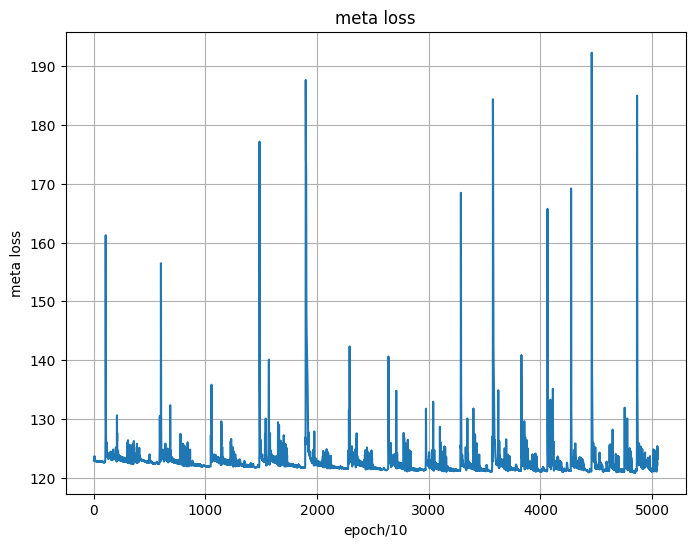

In [47]:
plot_loss_over_epoch(loss_history, 'meta loss','epoch/10','meta loss')

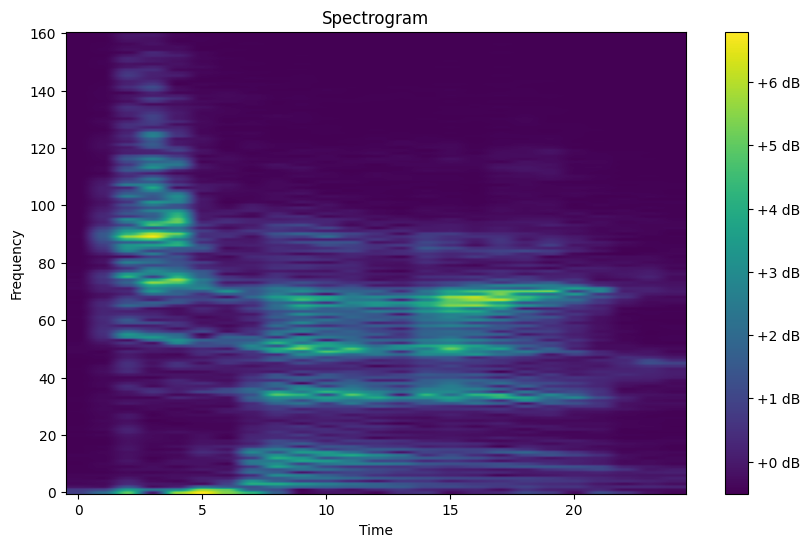

In [48]:
plot_spectrogram(inputs.detach())

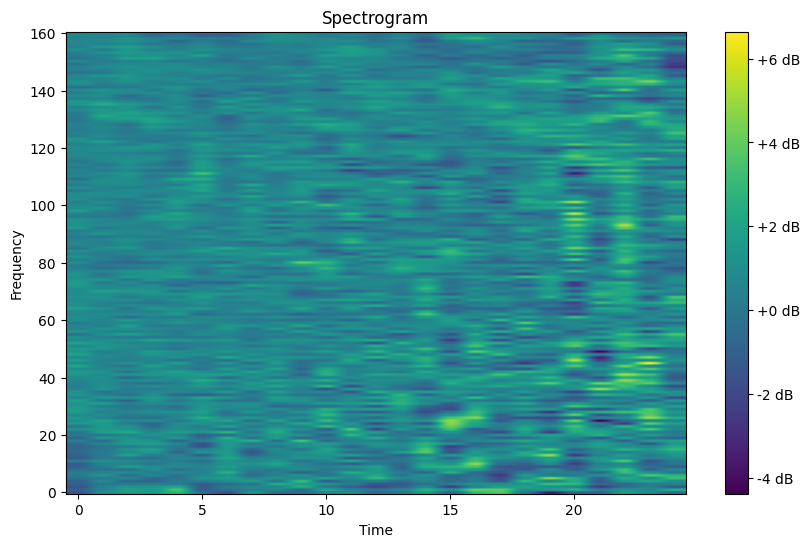

In [49]:
plot_spectrogram(x_hat.detach())

In [12]:
#pytorch 2nd order derivative test 
f = lambda x: x**3 + 2*x**2 - 3*x + 1
x = torch.tensor(1.0, requires_grad=True)

z = f(x)
y = z


dydx = torch.autograd.grad(y, x, create_graph=True)
d2ydx = torch.autograd.grad(dydx, x) # 10
print(dydx, d2ydx)

(tensor(4., grad_fn=<AddBackward0>),) (tensor(10.),)


In [43]:
plot_spectrogram(torch.abs(inputs.detach() - x_hat.detach()))

RuntimeError: The size of tensor a (25) must match the size of tensor b (20) at non-singleton dimension 3

In [121]:
x = torch.nn.Parameter(torch.rand_like(inputs).to(device),requires_grad=False)

In [124]:
import torch
import torch.nn.functional as F

def calculate_loss(x_hat):
    out, output_sizes, hs = model_ds(x_hat, input_sizes) # 1 176 29
    out = out.transpose(0, 1)  # TxNxH
    out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

    mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)
    return mloss

def unit_vector(size):
    # Function to generate a random unit vector of size d using PyTorch
    v = torch.randn(size).cuda()
    return v / torch.norm(v)

def optimize(x,  alpha, N, K):
    d = x.shape  # Dimension of x

    for iter in range(N):
        V = []

        loss_x = calculate_loss(x)
        print( 'iter: {:3d} loss: {:.4f}'.format(iter, loss_x))
        for _ in range(K):
            vk = unit_vector(d)  # Generate a random unit vector
            if calculate_loss(x + alpha * vk) < loss_x:
                V.append(vk)  # Add vk to set V

        if len(V) == 0:
            continue
        x += alpha *  torch.stack(V).mean(0) # Update x
    return x

# Example usage
alpha = 1  # Step size
N = 10000  # Number of iterations for outer loop
K = 128 # Number of iterations for inner loop

x_hat = optimize(x, alpha, N, K)

iter:   0 loss: 155.7148
iter:   1 loss: 155.3730
iter:   2 loss: 154.9108
iter:   3 loss: 154.4840
iter:   4 loss: 154.0014
iter:   5 loss: 153.5791
iter:   6 loss: 153.2215
iter:   7 loss: 152.8435
iter:   8 loss: 152.4766
iter:   9 loss: 152.1014
iter:  10 loss: 151.7996
iter:  11 loss: 151.4105
iter:  12 loss: 151.1254
iter:  13 loss: 150.7912
iter:  14 loss: 150.4493
iter:  15 loss: 150.1224
iter:  16 loss: 149.7913
iter:  17 loss: 149.4576
iter:  18 loss: 149.1345
iter:  19 loss: 148.7930
iter:  20 loss: 148.6142
iter:  21 loss: 148.3455
iter:  22 loss: 148.0031
iter:  23 loss: 147.6158
iter:  24 loss: 147.2973
iter:  25 loss: 146.9623
iter:  26 loss: 146.6244
iter:  27 loss: 146.1515
iter:  28 loss: 145.8121
iter:  29 loss: 145.4222
iter:  30 loss: 145.0123
iter:  31 loss: 144.6732
iter:  32 loss: 144.2514
iter:  33 loss: 143.8934
iter:  34 loss: 143.5739
iter:  35 loss: 143.2626
iter:  36 loss: 143.0424
iter:  37 loss: 142.6908
iter:  38 loss: 142.3792
iter:  39 loss: 142.0637


In [104]:
x_bak = x_hat.clone()

In [114]:
x_hat = x_bak.clone()

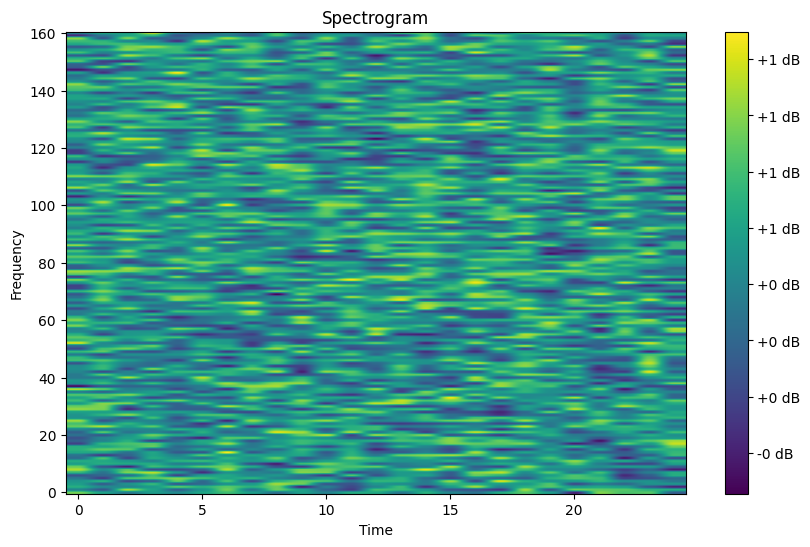

In [112]:
plot_spectrogram(x_hat.detach())

In [76]:
inputs

tensor([[[[ 0.8460,  2.0659,  4.9795,  ...,  0.5986, -0.1822, -0.4060],
          [ 0.7560,  1.0076,  3.6016,  ..., -0.2898, -0.2762, -0.3306],
          [-0.1792, -0.2546,  1.3042,  ...,  0.2836,  0.2925,  0.1865],
          ...,
          [-0.5047, -0.4850, -0.0970,  ..., -0.5068, -0.5067, -0.5072],
          [-0.5025, -0.4487, -0.0481,  ..., -0.5069, -0.5031, -0.5088],
          [-0.5062, -0.4687, -0.2649,  ..., -0.5033, -0.5054, -0.5005]]]],
       device='cuda:0')

In [67]:
k = [a,b]

In [68]:
k

[tensor([[-0.6290,  0.5593, -0.1678,  1.0688,  0.4475],
         [-2.1006, -0.9276,  1.2956,  1.0994,  0.3943],
         [-1.2641, -0.7537,  0.6979, -1.7180,  0.5256]]),
 tensor([[-0.5500,  1.0274, -1.2801, -0.4180, -1.0987],
         [-0.5693,  0.5684, -0.2736,  1.0614, -0.5568],
         [-2.8803,  1.3923,  0.3247, -0.4633, -1.0651]])]

In [75]:
torch.stack(k).mean(0).shape

torch.Size([3, 5])